In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import joblib

import lightgbm as lgb
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [52]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [53]:
raw_data = pd.read_csv('training_data/mean_reverse_training_data.csv')

In [54]:
training_data = raw_data.copy()
training_data['out'] = training_data['out'].apply(lambda x:1 if x == -1 else 0)
training_data = training_data.sort_values(by=['date'])
training_data = training_data[training_data.side == -1]
training_data = training_data[training_data.date > '2020-01-01']
print(f'training_data.shape : {training_data.shape}')

col_list = ['date', 'com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'out']
    
data = training_data[col_list]
train_data = data.iloc[:int(training_data.shape[0]*.7),:]
print(train_data.shape)
test_data = data.iloc[int(training_data.shape[0]*.7):,:]
print(test_data.shape)

training_data.shape : (21771, 51)
(15239, 49)
(6532, 49)


In [55]:
def Upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.out==0]
    df_minority = df[df.out==1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df.out.value_counts()[0],    # to match majority class
                                    random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    # Display new class counts
    print(f'before\n {df.out.value_counts()}')
    print(f'after\n {df_upsampled.out.value_counts()}')
    return df_upsampled

train_data_up = Upsample(train_data)
# test_data_up = Upsample(test_data)
# train_data_up = train_data_up.sample(frac=0.9, replace=True, random_state=1)

X = train_data_up.iloc[:,1:-1]
y = train_data_up.iloc[:,-1]
X_test = test_data.iloc[:,1:-1]
y_test = test_data.iloc[:,-1]

before
 0    8829
1    6410
Name: out, dtype: int64
after
 1    8829
0    8829
Name: out, dtype: int64


In [56]:
X.head()

,com_rev,d_yield,pb,AD,OBV,ADOSC,bias5,bias10,bias20,bias60,...,b_MA60,b_bias5,b_bias10,b_bias20,b_bias60,b_acc5,b_acc10,b_acc20,b_acc60,b_volatility
312201,0.545141,0.829545,0.162162,0.461082,0.394591,0.259963,0.245649,0.305462,0.353893,0.183970,...,0.0,0.568061,0.534916,0.454489,0.531943,0.405981,0.57264,0.543531,0.350727,0.282616
335927,0.028938,0.544643,0.862319,0.998662,0.131127,0.790100,0.045355,0.032115,0.077011,0.141014,...,0.0,0.568061,0.534916,0.454489,0.531943,0.405981,0.57264,0.543531,0.350727,0.282616
126699,0.257102,0.358209,0.077273,0.729192,0.020953,0.421255,0.293563,0.224709,0.273439,0.501775,...,0.0,0.568061,0.534916,0.454489,0.531943,0.405981,0.57264,0.543531,0.350727,0.282616
207829,0.621208,0.018325,0.202703,0.527471,0.020825,0.355676,0.241431,0.221730,0.191454,0.277127,...,0.0,0.568061,0.534916,0.454489,0.531943,0.405981,0.57264,0.543531,0.350727,0.282616
213955,0.541833,0.904459,0.242991,0.360714,0.923632,0.812519,0.000000,0.000000,0.027394,0.066814,...,0.0,0.568061,0.534916,0.454489,0.531943,0.405981,0.57264,0.543531,0.350727,0.282616


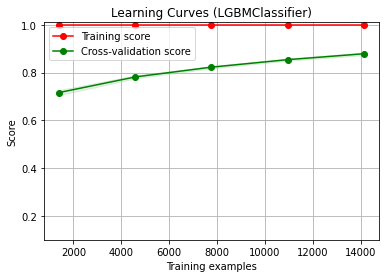

In [63]:
# digits = load_digits()
# X, y = digits.data, digits.target


title = "Learning Curves (LGBMClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# estimator = BernoulliNB()
estimator = lgb.LGBMClassifier(objective = 'binary', 
                                learning_rate = 0.05, 
                                n_estimators = 3000, 
                                random_state=0)
plot_learning_curve(estimator, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4)

# title = "Learning Curves (ExtraTreesClassifier)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = RandomForestClassifier(max_depth=15, random_state=0, n_estimators=500, bootstrap=True)
# estimator = ExtraTreesClassifier(
#     n_estimators=100, criterion="entropy", random_state=0, class_weight='balanced',
#     warm_start=True, bootstrap=True
#     )
# # plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
# #                         n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
# plot_learning_curve(estimator, title, X, y, (0.1, 1.01), cv=cv, n_jobs=4)

plt.show()

In [68]:
# ex_clf = ExtraTreesClassifier(
#     n_estimators=1000, criterion="entropy", random_state=0, class_weight='balanced',
#     warm_start=True, bootstrap=True
#     )
# ex_clf = RandomForestClassifier(max_depth=15, random_state=42, n_estimators=500, bootstrap=True)
# ex_clf.fit(X, y)
ex_clf = lgb.LGBMClassifier(objective = 'binary', 
                                learning_rate = 0.05, 
                                n_estimators = 500, 
                                random_state=47)
# ex_clf = BernoulliNB()
ex_clf.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=47, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [69]:
model = ex_clf
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.11%


              precision    recall  f1-score   support

           0       0.56      0.88      0.68      3264
           1       0.72      0.31      0.43      3268

    accuracy                           0.59      6532
   macro avg       0.64      0.59      0.56      6532
weighted avg       0.64      0.59      0.56      6532

Confusion Matrix
[[2865  399]
 [2260 1008]]

Accuracy
0.5929271279853031


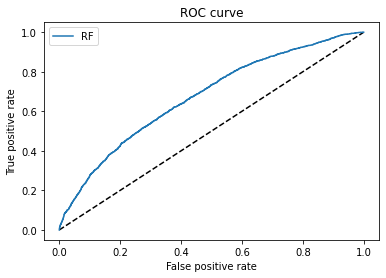

In [66]:
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

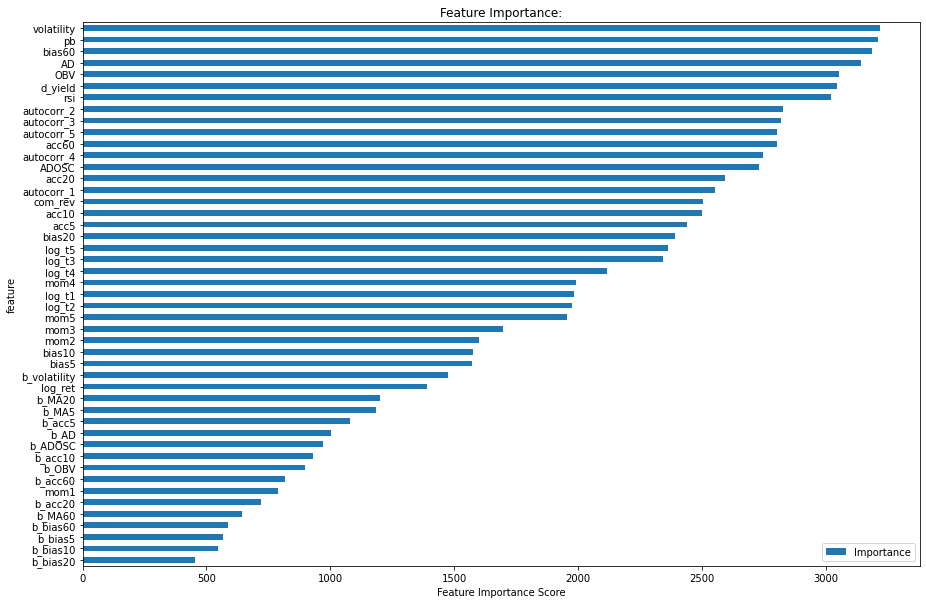

In [67]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 10)

feat_imp = pd.DataFrame({'Importance':model.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [62]:
joblib.dump(model,'lazypredict/mr_short_BernoulliNB_0419.pkl')

['lazypredict/mr_long_BernoulliNB_0419.pkl']